In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns # 引入 seaborn 来使用更专业的调色板
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats

# 设置字体为Arial
plt.rcParams['font.family'] = 'Arial'

# 读取可行性分析结果数据
data_path = Path("../result/island_viability_summary_electric.csv")
df = pd.read_csv(data_path)

# 显示数据概况
print(f"数据形状: {df.shape}")
print(f"情景列表: {df['scenario'].unique()}")
print(f"Viability gap统计:")
print(df['viability_gap'].describe())

数据形状: (10980, 16)
情景列表: ['output_0' 'output_2020' 'output_2050' 'output_future_2030'
 'output_future_2040' 'output_future_2050']
Viability gap统计:
count    10980.000000
mean        -0.425257
std          0.739480
min         -4.148942
25%         -1.006200
50%          0.043717
75%          0.082420
max          0.954005
Name: viability_gap, dtype: float64


成功分配IPCC区域，共有 43 个区域
有效区域 (岛屿数量>10): 39 个
有效区域列表: ['SEA', 'EAS', 'NEU', 'MED', 'EPO', 'SAS', 'SPO', 'CAR', 'ENA', 'WAF', 'NAU', 'NAO', 'SWS', 'NWN', 'WNA', 'ARP', 'SCA', 'NPO', 'NZ', 'BOB', 'SSA', 'RFE', 'MDG', 'NCA', 'SAH', 'SAU', 'WCA', 'WCE', 'SEAF', 'NEN', 'ESAF', 'EIO', 'NES', 'EAU', 'SIO', 'GIC', 'CAF', 'EAO', 'NSA']
开始创建云雨图...
ipcc_region列存在，共有 43 个区域
基础数据: 1826 个岛屿
2020对比数据: 1826 个岛屿
2050对比数据: 1826 个岛屿
2020变化数据形状: (1828, 5), 列: ['island_id', 'tariff_breakeven_base', 'ipcc_region_base', 'tariff_breakeven_compare', 'position_change']
2050变化数据形状: (1828, 5), 列: ['island_id', 'tariff_breakeven_base', 'ipcc_region_base', 'tariff_breakeven_compare', 'position_change']
2020显著变化岛屿数: 171
2050显著变化岛屿数: 208
发现在至少一个scenario中有显著变化的区域: 20 个
区域列表: ['SAU', 'GIC', 'NAU', 'NWN', 'ARP', 'NEU', 'SPO', 'SWS', 'ENA', 'SSA', 'SEA', 'NPO', 'NEN', 'MDG', 'RFE', 'SIO', 'NZ', 'WNA', 'BOB', 'EAS']
开始生成云雨图...
区域 SAU: 2020变化数据 8 个, 2050变化数据 8 个
区域 GIC: 2020变化数据 2 个, 2050变化数据 2 个
区域 NAU: 2020变化数据 30 个, 2050变化数

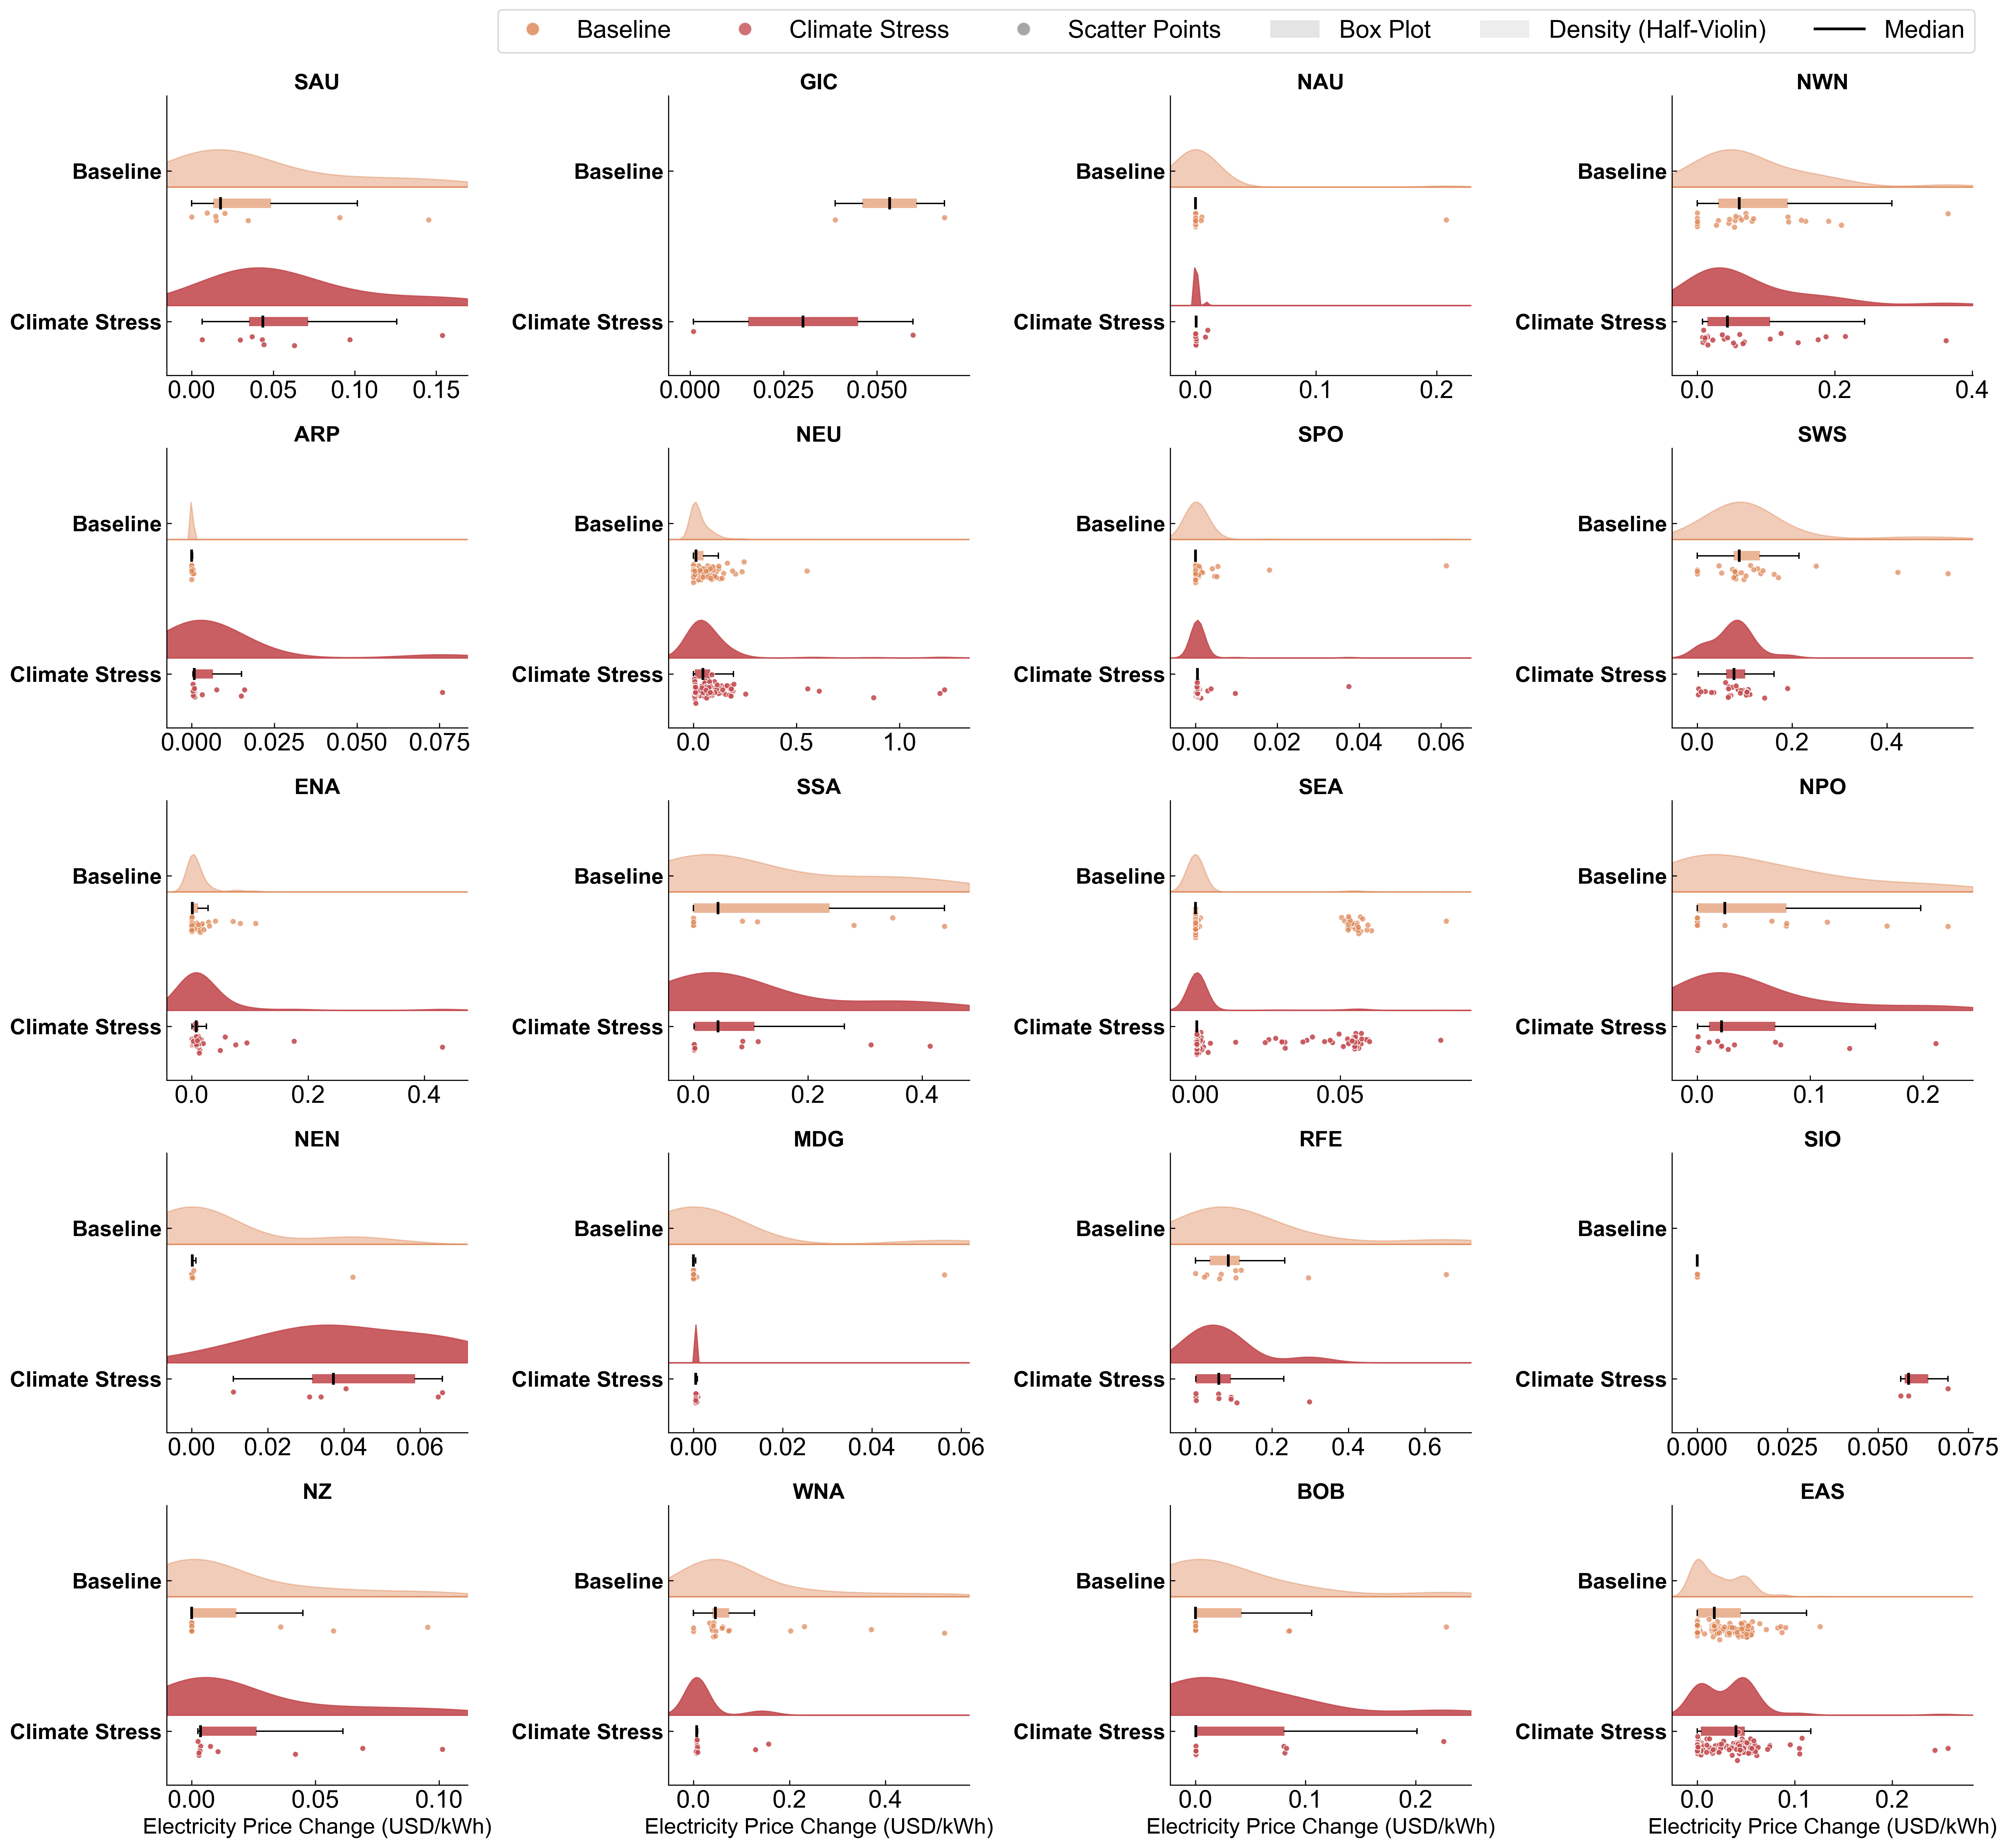


=== 区域变化统计 ===

SAU:
  2020: 8 islands, median = 0.018, max = 0.145
  2050: 8 islands, median = 0.044, max = 0.154

GIC:
  2020: 2 islands, median = 0.053, max = 0.068
  2050: 2 islands, median = 0.030, max = 0.060

NAU:
  2020: 30 islands, median = 0.000, max = 0.208
  2050: 30 islands, median = 0.001, max = 0.010

NWN:
  2020: 25 islands, median = 0.061, max = 0.365
  2050: 25 islands, median = 0.044, max = 0.362

ARP:
  2020: 14 islands, median = 0.000, max = 0.001
  2050: 14 islands, median = 0.001, max = 0.076

NEU:
  2020: 154 islands, median = 0.012, max = 0.551
  2050: 154 islands, median = 0.046, max = 1.218

SPO:
  2020: 84 islands, median = 0.000, max = 0.061
  2050: 84 islands, median = 0.001, max = 0.037

SWS:
  2020: 26 islands, median = 0.089, max = 0.529
  2050: 26 islands, median = 0.078, max = 0.190

ENA:
  2020: 45 islands, median = 0.001, max = 0.110
  2050: 45 islands, median = 0.007, max = 0.431

SSA:
  2020: 10 islands, median = 0.043, max = 0.439
  2050: 10 isl

In [67]:
# --- 数据处理函数 ---
def assign_ipcc_region(lat, lon, ipcc_regions_gdf):
    """将岛屿坐标分配到IPCC区域"""
    point = Point(lon, lat)
    possible_matches_index = list(ipcc_regions_gdf.sindex.intersection(point.bounds))
    possible_matches = ipcc_regions_gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.contains(point)]
    if not precise_matches.empty:
        return precise_matches.iloc[0]['Acronym']
    return 'Unknown'

def calculate_position_change(df_base, df_compare):
    """计算两个情景之间的位置变化 - 修正版，包含IPCC区域信息"""
    # 修正：合并时包含ipcc_region信息
    merged = pd.merge(df_base[['island_id', 'tariff_breakeven', 'ipcc_region']],
                      df_compare[['island_id', 'tariff_breakeven']],
                      on='island_id', suffixes=('_base', '_compare'))
    merged['position_change'] = abs(merged['tariff_breakeven_compare'] - merged['tariff_breakeven_base'])
    # 重命名ipcc_region列以保持一致性
    merged = merged.rename(columns={'ipcc_region': 'ipcc_region_base'})
    return merged

# --- 1. 数据加载和预处理 ---
try:
    ipcc_regions = gpd.read_file("IPCC-WGI-reference-regions-v4.geojson")
    ipcc_regions.sindex  # 创建空间索引
    df['ipcc_region'] = df.apply(lambda row: assign_ipcc_region(row['lat'], row['lon'], ipcc_regions), axis=1)
    print(f"成功分配IPCC区域，共有 {df['ipcc_region'].nunique()} 个区域")
except Exception as e:
    print(f"无法加载 geojson 文件或处理数据: {e}.")
    df['ipcc_region'] = 'Unknown'

# 筛选出有效区域（岛屿数量足够的区域）
MIN_ISLANDS_PER_REGION = 10
region_counts = df['ipcc_region'].value_counts()
valid_regions = region_counts[region_counts > MIN_ISLANDS_PER_REGION].index.tolist()
print(f"有效区域 (岛屿数量>{MIN_ISLANDS_PER_REGION}): {len(valid_regions)} 个")
print(f"有效区域列表: {valid_regions}")

def create_raincloud_plot(data_2020, data_2050, ax, region_name, color_2020, color_2050):
    """
    创建改进的云雨图：每个scenario占据上下两个区域，每个区域内从下到上是点-箱线图-半小提琴图
    
    Args:
        data_2020: 2020情景的变化值数据
        data_2050: 2050情景的变化值数据
        ax: matplotlib轴对象
        region_name: IPCC区域名称
        color_2020, color_2050: 两个情景的颜色
    """
    # 计算数据范围
    all_data = np.concatenate([data_2020, data_2050])
    if len(all_data) == 0:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{region_name}', fontsize=10, pad=10, fontweight='bold')
        return
        
    x_min, x_max = all_data.min(), all_data.max()
    x_range = x_max - x_min if x_max != x_min else 1
    x_padding = x_range * 0.1
    
    # 设置y轴位置（分为上下两个区域，层级更紧密）
    # 2020 scenario（上半部分：0.52-1.0）
    y_2020_points = 0.56    # 2020散点
    y_2020_box = 0.62       # 2020箱线图
    y_2020_violin = 0.68    # 2020小提琴图基准线
    
    # 2050 scenario（下半部分：0.0-0.48）
    y_2050_points = 0.12    # 2050散点
    y_2050_box = 0.18       # 2050箱线图
    y_2050_violin = 0.24    # 2050小提琴图基准线
    
    np.random.seed(42)  # 确保结果可重现
    
    # === 2020 Scenario（上半部分）===
    if len(data_2020) > 0:
        # 1. 散点图（最下层）
        y_jitter_2020 = np.random.normal(y_2020_points, 0.015, len(data_2020))
        ax.scatter(data_2020, y_jitter_2020, alpha=0.7, s=18, 
                  color=color_2020, edgecolors='white', linewidth=0.5, zorder=3)
        
        # 2. 箱线图（中间层）
        q25, q50, q75 = np.percentile(data_2020, [25, 50, 75])
        iqr = q75 - q25
        whisker_low = max(data_2020.min(), q25 - 1.5 * iqr)
        whisker_high = min(data_2020.max(), q75 + 1.5 * iqr)
        
        # 箱体（稍微小一些）
        box_height = 0.035
        ax.add_patch(plt.Rectangle((q25, y_2020_box - box_height/2), q75 - q25, box_height,
                                  facecolor=color_2020, alpha=0.6, zorder=2))
        # 中位数线
        ax.plot([q50, q50], [y_2020_box - box_height/2, y_2020_box + box_height/2], 
               color='black', linewidth=2, zorder=4)
        # 须线
        ax.plot([whisker_low, q25], [y_2020_box, y_2020_box], color='black', linewidth=1, zorder=2)
        ax.plot([q75, whisker_high], [y_2020_box, y_2020_box], color='black', linewidth=1, zorder=2)
        ax.plot([whisker_low, whisker_low], [y_2020_box - box_height/4, y_2020_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        ax.plot([whisker_high, whisker_high], [y_2020_box - box_height/4, y_2020_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        
        # 3. 半小提琴图（上层，只显示向上的部分）
        if len(data_2020) > 3:
            try:
                kde_2020 = stats.gaussian_kde(data_2020)
                x_kde = np.linspace(x_min - x_padding, x_max + x_padding, 100)
                density_2020 = kde_2020(x_kde)
                # 归一化密度并缩放（稍微小一些）
                density_2020_scaled = density_2020 / density_2020.max() * 0.14
                
                # 只向上填充（半小提琴）
                ax.fill_between(x_kde, y_2020_violin, y_2020_violin + density_2020_scaled, 
                              alpha=0.4, color=color_2020, zorder=1)
                # 底边线
                ax.plot(x_kde, [y_2020_violin] * len(x_kde), color=color_2020, linewidth=1, alpha=0.8, zorder=1)
            except:
                pass
    
    # === 2050 Scenario（下半部分）===
    if len(data_2050) > 0:
        # 1. 散点图（最下层）
        y_jitter_2050 = np.random.normal(y_2050_points, 0.015, len(data_2050))
        ax.scatter(data_2050, y_jitter_2050, alpha=0.9, s=18, 
                  color=color_2050, edgecolors='white', linewidth=0.5, zorder=3)
        
        # 2. 箱线图（中间层）
        q25, q50, q75 = np.percentile(data_2050, [25, 50, 75])
        iqr = q75 - q25
        whisker_low = max(data_2050.min(), q25 - 1.5 * iqr)
        whisker_high = min(data_2050.max(), q75 + 1.5 * iqr)
        
        # 箱体（稍微小一些）
        box_height = 0.035
        ax.add_patch(plt.Rectangle((q25, y_2050_box - box_height/2), q75 - q25, box_height,
                                  facecolor=color_2050, alpha=0.9, zorder=2))
        # 中位数线
        ax.plot([q50, q50], [y_2050_box - box_height/2, y_2050_box + box_height/2], 
               color='black', linewidth=2, zorder=4)
        # 须线
        ax.plot([whisker_low, q25], [y_2050_box, y_2050_box], color='black', linewidth=1, zorder=2)
        ax.plot([q75, whisker_high], [y_2050_box, y_2050_box], color='black', linewidth=1, zorder=2)
        ax.plot([whisker_low, whisker_low], [y_2050_box - box_height/4, y_2050_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        ax.plot([whisker_high, whisker_high], [y_2050_box - box_height/4, y_2050_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        
        # 3. 半小提琴图（上层，只显示向上的部分）
        if len(data_2050) > 3:
            try:
                kde_2050 = stats.gaussian_kde(data_2050)
                x_kde = np.linspace(x_min - x_padding, x_max + x_padding, 100)
                density_2050 = kde_2050(x_kde)
                # 归一化密度并缩放（稍微小一些）
                density_2050_scaled = density_2050 / density_2050.max() * 0.14
                
                # 只向上填充（半小提琴）
                ax.fill_between(x_kde, y_2050_violin, y_2050_violin + density_2050_scaled, 
                              alpha=0.9, color=color_2050, zorder=1)
                # 底边线
                ax.plot(x_kde, [y_2050_violin] * len(x_kde), color=color_2050, linewidth=1, alpha=0.8, zorder=1)
            except:
                pass
    
    # 4. 设置轴和标签
    ax.set_ylim(-0.02, 1.02)
    
    # 设置y轴标签，标识两个scenario区域
    ax.set_yticks([0.18, 0.74])  # 在每个scenario的中间位置
    ax.set_yticklabels(['Climate Stress', 'Baseline'], fontsize=16, fontweight='bold')
    
    ax.set_title(f'{region_name}', fontsize=16, pad=5, fontweight='bold')
    ax.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # 设置x轴范围
    ax.set_xlim(x_min - x_padding, x_max + x_padding)


# 主程序：创建多子图云雨图
if __name__ == '__main__':
    print("开始创建云雨图...")
    
    # 检查ipcc_region列是否存在
    if 'ipcc_region' not in df.columns:
        print("错误：ipcc_region列不存在！")
    else:
        print(f"ipcc_region列存在，共有 {df['ipcc_region'].nunique()} 个区域")
    
    # 计算变化数据（使用修正后的逻辑）
    df_base_2020 = df[(df['scenario'] == 'output_0') & (df['ipcc_region'].isin(valid_regions))].copy()
    df_compare_2020 = df[(df['scenario'] == 'output_2020') & (df['ipcc_region'].isin(valid_regions))].copy()
    df_compare_2050 = df[(df['scenario'] == 'output_2050') & (df['ipcc_region'].isin(valid_regions))].copy()

    print(f"基础数据: {len(df_base_2020)} 个岛屿")
    print(f"2020对比数据: {len(df_compare_2020)} 个岛屿")
    print(f"2050对比数据: {len(df_compare_2050)} 个岛屿")

    # 计算变化 - 现在包含IPCC区域信息
    change_2020 = calculate_position_change(df_base_2020, df_compare_2020)
    change_2050 = calculate_position_change(df_base_2020, df_compare_2050)
    
    print(f"2020变化数据形状: {change_2020.shape}, 列: {change_2020.columns.tolist()}")
    print(f"2050变化数据形状: {change_2050.shape}, 列: {change_2050.columns.tolist()}")
    
    # 筛选有显著变化的区域
    significant_2020 = change_2020[change_2020['position_change'] > 0.05]
    significant_2050 = change_2050[change_2050['position_change'] > 0.05]
    
    print(f"2020显著变化岛屿数: {len(significant_2020)}")
    print(f"2050显著变化岛屿数: {len(significant_2050)}")
    
    # 获取在两个scenario中都有显著变化的区域
    regions_2020 = set(significant_2020['ipcc_region_base'].unique()) if len(significant_2020) > 0 else set()
    regions_2050 = set(significant_2050['ipcc_region_base'].unique()) if len(significant_2050) > 0 else set()
    common_regions = list(regions_2020.union(regions_2050))  # 使用并集，显示所有有变化的区域
    
    print(f"发现在至少一个scenario中有显著变化的区域: {len(common_regions)} 个")
    print(f"区域列表: {common_regions}")
    
    if len(common_regions) == 0:
        print("没有发现有显著变化的区域")
    else:
        print("开始生成云雨图...")
        # 计算子图布局
        n_regions = len(common_regions)
        n_cols = min(4, n_regions)  # 最多4列
        n_rows = (n_regions + n_cols - 1) // n_cols  # 向上取整
        
        # 创建图形
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.2*n_cols, 4*n_rows), dpi=300)
        if n_regions == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.flatten()
        else:
            axes = axes.flatten()
        
        # 定义颜色
        color_2020 = '#DD8452'  
        color_2050 = '#C44E52' 
        
        # 为每个区域创建子图
        for i, region in enumerate(common_regions):
            ax = axes[i]
            
            # 获取该区域在两个scenario下的变化数据
            region_data_2020 = change_2020[change_2020['ipcc_region_base'] == region]['position_change'].values
            region_data_2050 = change_2050[change_2050['ipcc_region_base'] == region]['position_change'].values
            
            print(f"区域 {region}: 2020变化数据 {len(region_data_2020)} 个, 2050变化数据 {len(region_data_2050)} 个")
            
            # 绘制改进的云雨图
            create_raincloud_plot(region_data_2020, region_data_2050, ax, 
                                region, color_2020, color_2050)
        
        # 隐藏多余的子图
        for i in range(n_regions, len(axes)):
            axes[i].set_visible(False)
        
        # 为所有子图添加统一的x轴标签
        for i in range(n_regions):
            if i >= (n_rows-1) * n_cols:  # 最后一行
                axes[i].set_xlabel('Electricity Price Change (USD/kWh)', fontsize=16)
        
        # 添加图例
        from matplotlib.lines import Line2D
        from matplotlib.patches import Patch
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color_2020, 
                  markersize=10, label='Baseline', alpha=0.8),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color_2050, 
                  markersize=10, label='Climate Stress', alpha=0.8),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
                  markersize=10, label='Scatter Points', alpha=0.7),
            Patch(facecolor='lightgray', alpha=0.6, label='Box Plot'),
            Patch(facecolor='lightgray', alpha=0.4, label='Density (Half-Violin)'),
            Line2D([0], [0], color='black', linewidth=2, label='Median')
        ]
        fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.95), ncol=6, fontsize=18)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.90)
        plt.show()
        
        # 打印统计信息
        print(f"\n=== 区域变化统计 ===")
        for region in common_regions:
            data_2020 = change_2020[change_2020['ipcc_region_base'] == region]['position_change'].values
            data_2050 = change_2050[change_2050['ipcc_region_base'] == region]['position_change'].values
            
            print(f"\n{region}:")
            if len(data_2020) > 0:
                print(f"  2020: {len(data_2020)} islands, median = {np.median(data_2020):.3f}, max = {np.max(data_2020):.3f}")
            if len(data_2050) > 0:
                print(f"  2050: {len(data_2050)} islands, median = {np.median(data_2050):.3f}, max = {np.max(data_2050):.3f}")

ipcc_region列已存在，开始分析...

--- 正在对比三个情景，但只显示在 'output_0' 和 'output_2020' 之间有显著变化的岛屿 ---
发现 171 个有显著变化的岛屿（在 output_0 和 output_2020 之间）。


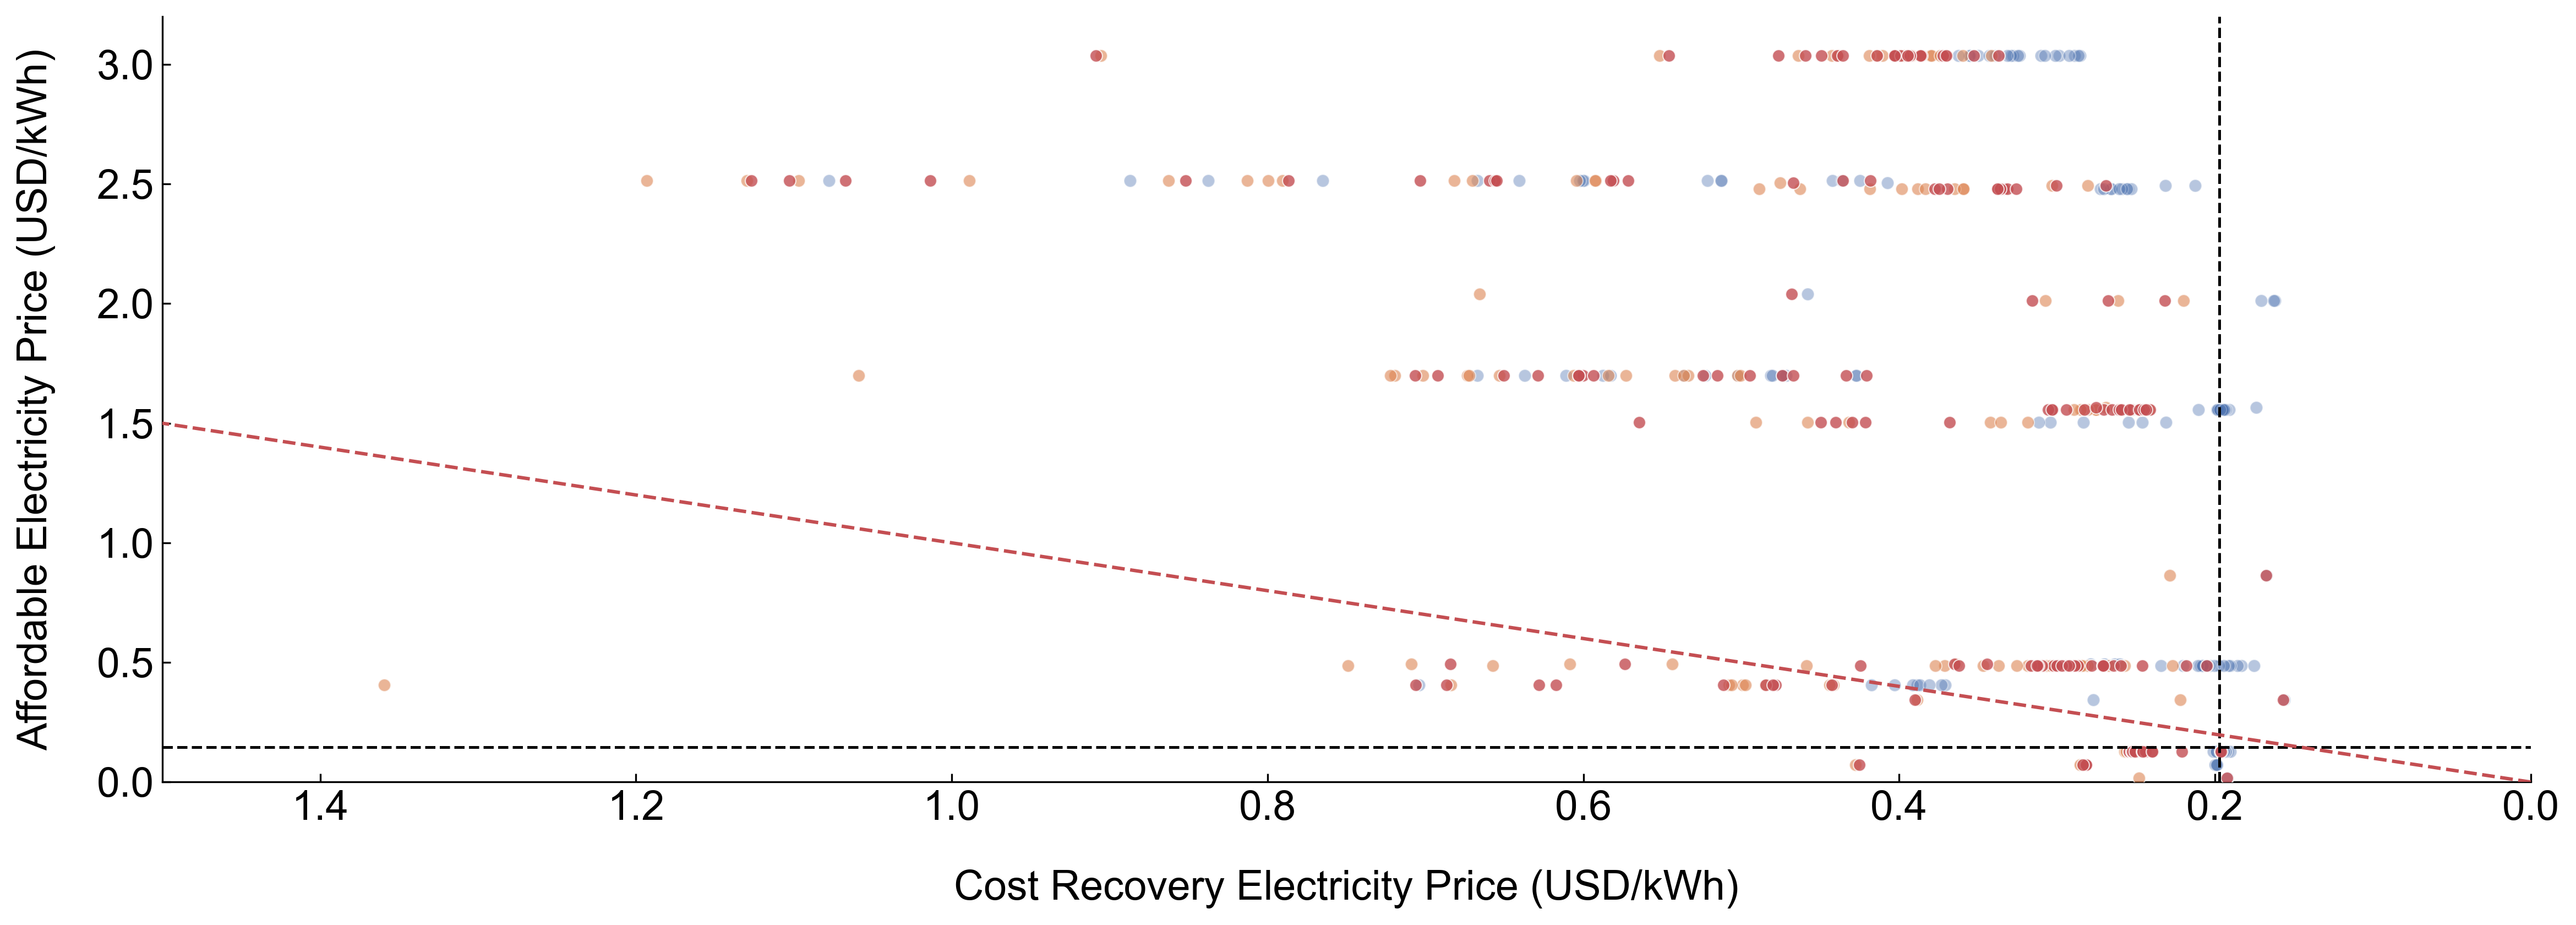


--- 统计分析结果 (仅针对显著变化的岛屿) ---
                High Affordable \nLow Cost  High Affordable \nHigh Cost  \
Scenario                                                                  
Ideal                                   28                          108   
Baseline                                 0                          136   
Climate Stress                           2                          134   

                Low Affordable \nLow Cost  Low Affordable \nHigh Cost  \
Scenario                                                                
Ideal                                  21                          14   
Baseline                                0                          35   
Climate Stress                          3                          32   

                Unaffordable  
Scenario                      
Ideal                     37  
Baseline                  50  
Climate Stress            47  
--------------------------------------------------


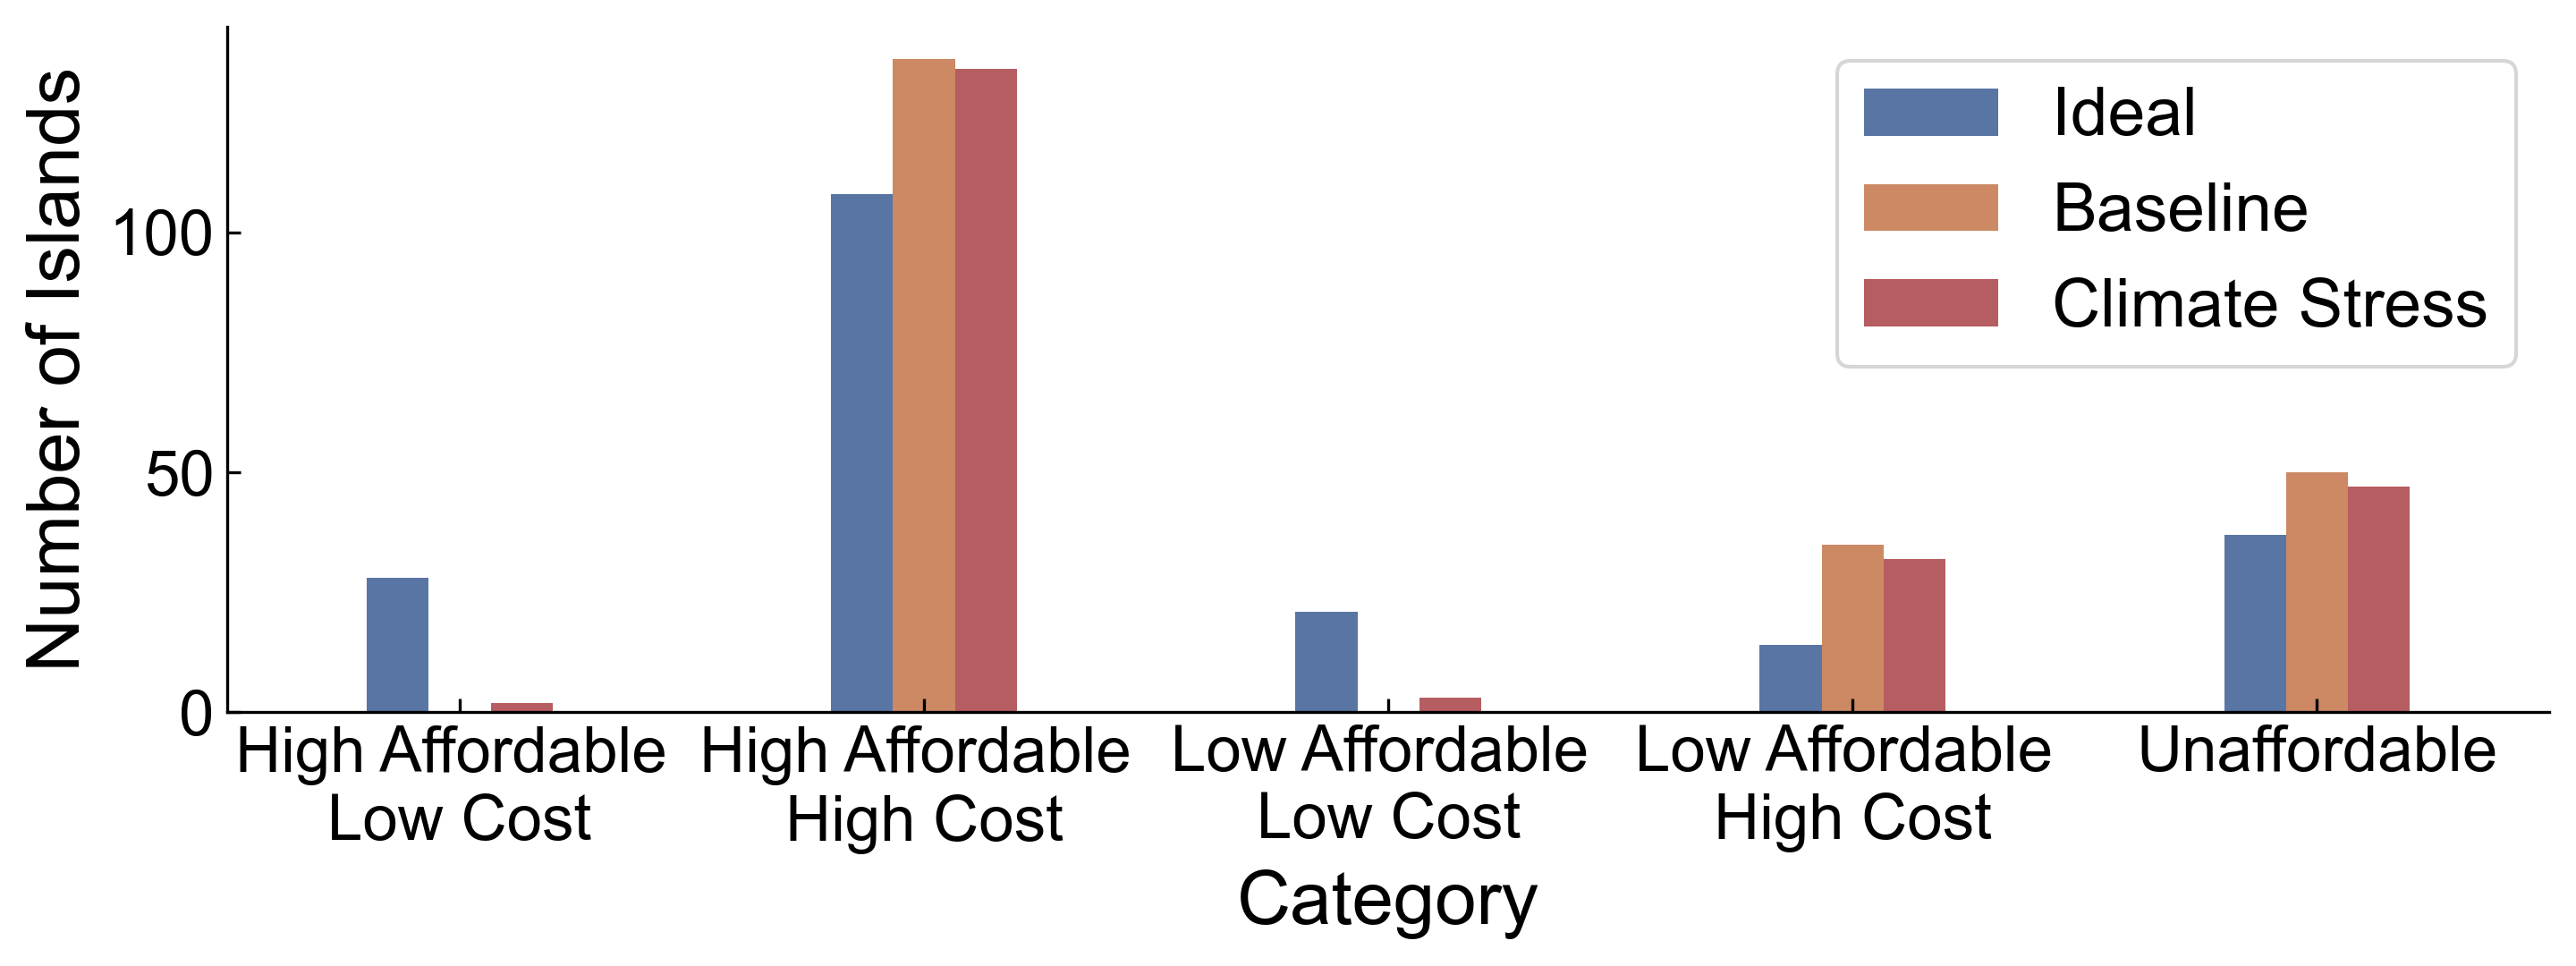

In [80]:
# --- Nature 风格图表设置 ---
# 在绘图前全局设置字体、字号等参数
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 20,  # 基础字号可以稍小，具体元素再调整
    'axes.labelsize': 18,
    'axes.titlesize': 16,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    'figure.dpi': 300,
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.direction': 'in', # 刻度线朝内
    'ytick.direction': 'in', # 刻度线朝内
})


# --- NEW: 新增的统计分析与绘图函数 ---
def analyze_and_plot_statistics(df_analysis, scenario_config, median_breakeven, median_affordable):
    """
    对数据进行象限和可负担性分析，并绘制条形图。
    """
    results = []
    
    # 1. 遍历每个情景进行统计
    for scenario_name, config in scenario_config.items():
        scenario_df = df_analysis[df_analysis['scenario'] == scenario_name].copy()
        if scenario_df.empty:
            continue
            
        # 定义象限条件
        is_viable = (scenario_df['tariff_breakeven'] <= median_breakeven) & (scenario_df['tariff_affordable'] >= median_affordable)
        is_marginal = (scenario_df['tariff_breakeven'] >= median_breakeven) & (scenario_df['tariff_affordable'] >= median_affordable)
        is_limited = (scenario_df['tariff_breakeven'] <= median_breakeven) & (scenario_df['tariff_affordable'] <= median_affordable)
        is_challenging = (scenario_df['tariff_breakeven'] >= median_breakeven) & (scenario_df['tariff_affordable'] <= median_affordable)
        is_unaffordable = scenario_df['tariff_breakeven'] >= scenario_df['tariff_affordable']
        
        # 统计数量
        counts = {
            'Scenario': config['label'],
            'High Affordable \nLow Cost': is_viable.sum(),
            'High Affordable \nHigh Cost': is_marginal.sum(),
            'Low Affordable \nLow Cost': is_limited.sum(),
            'Low Affordable \nHigh Cost': is_challenging.sum(),
            'Unaffordable': is_unaffordable.sum()
        }
        results.append(counts)
        
    if not results:
        print("没有可供分析的数据。")
        return
        
    # 2. 创建并打印统计结果的DataFrame
    stats_df = pd.DataFrame(results).set_index('Scenario')
    print("\n--- 统计分析结果 (仅针对显著变化的岛屿) ---")
    print(stats_df)
    print("-" * 50)
    
    # 3. 准备绘图数据
    stats_df_melted = stats_df.reset_index().melt(
        id_vars='Scenario',
        var_name='Category',
        value_name='Number of Islands'
    )
    
    # 提取颜色用于绘图
    palette = {config['label']: config['color'] for config in scenario_config.values()}
    
    # 定义nature系列的颜色调色板（5种颜色）
    nature_colors = ['#2E8B57', '#FF8C00', '#4682B4', '#DC143C', '#8B4513']  # 森林绿、橙、钢蓝、深红、棕色
    
    # 4. 创建条形图
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    
    # 使用seaborn绘制条形图
    bars = sns.barplot(
        data=stats_df_melted,
        x='Category',
        y='Number of Islands',
        hue='Scenario',
        palette=palette,
        ax=ax,
        width=0.4
    )
    
    # 美化图表
    # ax.set_title(f'Statistical Distribution of Islands by Category ({scenario_name})', fontsize=14, pad=15)
    ax.set_xlabel('Category', fontsize=20)
    ax.set_ylabel('Number of Islands', fontsize=20)
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', labelsize=17)
    ax.legend()  # 移除title='Scenario'
    
    # 在条形图上添加数字标签
    # for p in ax.patches:
    #     height = p.get_height()
    #     if height > 0:  # 只在非零值上添加标签
    #         ax.annotate(f'{int(height)}', 
    #                     (p.get_x() + p.get_width() / 2., height), 
    #                     ha='center', va='center', 
    #                     xytext=(0, 9), 
    #                     textcoords='offset points',
    #                     fontsize=16)

    fig.tight_layout()
    plt.show()

# --- 核心绘图函数（修改为plot_feasibility_quadrant样式） ---
def plot_three_scenario_changes(df, base_scenario, final_scenario, zoom_config, scenario_config, change_threshold=0.1):
    """
    筛选出在首尾情景间有显著变化的岛屿，绘制它们的位置，并进行统计分析。
    使用plot_feasibility_quadrant的样式。
    """
    if df.empty:
        print("数据为空，跳过绘图。")
        return

    # 1. 筛选出用于计算变化的起始和最终情景数据
    df_base = df[df['scenario'] == base_scenario]
    df_final = df[df['scenario'] == final_scenario]
    
    if df_base.empty or df_final.empty:
        print(f"缺少 {base_scenario} 或 {final_scenario} 的数据，无法计算变化。")
        return

    # 2. 计算并筛选出有显著变化的岛屿
    change_data = calculate_position_change(df_base, df_final)
    significant_changes = change_data[change_data['position_change'] > change_threshold]
    
    if significant_changes.empty:
        print(f"在阈值 {change_threshold} 下未发现显著变化的岛屿。")
        return
        
    significant_island_ids = significant_changes['island_id'].unique()
    print(f"发现 {len(significant_island_ids)} 个有显著变化的岛屿（在 {base_scenario} 和 {final_scenario} 之间）。")

    # 3. 从原始数据中筛选出这些岛屿在 *所有情景* 中的数据
    df_plot = df[df['island_id'].isin(significant_island_ids)].copy()

    # === 使用plot_feasibility_quadrant的样式 ===
    fig, ax = plt.subplots(figsize=(16, 6),dpi=300)  # 使用相同的图形尺寸

    # --- 绘制主散点图 ---
    for scenario_name, config in scenario_config.items():
        scenario_df = df_plot[df_plot['scenario'] == scenario_name]
        if not scenario_df.empty:
            ax.scatter(scenario_df['tariff_breakeven'], scenario_df['tariff_affordable'],
                       color=config['color'],
                       label=config['label'],
                       alpha=config['alpha'], s=config['size'], edgecolors='white', linewidth=0.5, zorder=3)

    # --- 设置坐标轴和标题 ---
    ax.set_xlabel('Cost Recovery Electricity Price (USD/kWh)', labelpad=18)  # 使用相同的标签和间距
    ax.set_ylabel('Affordable Electricity Price (USD/kWh)', labelpad=18)
    # ax.set_title(f'Island Energy System Feasibility ({scenario_name})', weight='bold', size=12)

    # --- 翻转横轴，让低成本在右边 ---
    ax.invert_xaxis()  # 添加横轴翻转

    # --- "Despine" - 移除顶部和右侧轴线 ---
    ax.spines[['right', 'top']].set_visible(False)

    # --- 添加辅助线 ---
    median_breakeven = df_base['tariff_breakeven'].median()  # 使用基础情景的中位数
    median_affordable = df_base['tariff_affordable'].median()
    ax.axvline(x=median_breakeven, color='black', linestyle='--', linewidth=1.2, zorder=3)  # 使用相同的线条样式
    ax.axhline(y=median_affordable, color='black', linestyle='--', linewidth=1.2, zorder=3)

    ax.set_xlim(1.5, 0)
    ax.set_ylim(0, 3.2)

    # 45度线
    lim_min = min(ax.get_xlim()[0], ax.get_ylim()[0])
    lim_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([lim_min, lim_max], [lim_min, lim_max], color='#C44E52', linestyle='--', 
              alpha=1, linewidth=1.5, label='Break-even line', zorder=3)  # 使用相同的45度线样式
    ax.grid(False)  # 关闭网格

    # --- 创建放大视图 ---
    # zoom_data = df_plot[
    #     (df_plot['tariff_breakeven'].between(zoom_config['x_min'], zoom_config['x_max'])) &
    #     (df_plot['tariff_affordable'].between(zoom_config['y_min'], zoom_config['y_max']))
    # ]
    
    # if not zoom_data.empty:
    #     # 创建主子图
    #     inset_ax = ax.inset_axes([0.1, 0.35, 0.65, 0.65])  # 使用相同的放大视图位置和大小
        
    #     # 创建divider来添加边际图
    #     divider = make_axes_locatable(inset_ax)
        
    #     # 添加上方和右方的边际图
    #     ax_top = divider.append_axes("top", size="25%", pad=0.05, sharex=inset_ax)
    #     ax_right = divider.append_axes("right", size="25%", pad=0.05, sharey=inset_ax)
        
    #     # 隐藏边际图的刻度标签
    #     plt.setp(ax_top.get_xticklabels(), visible=False)
    #     plt.setp(ax_right.get_yticklabels(), visible=False)
        
    #     # 绘制主散点图
    #     for scenario_name, config in scenario_config.items():
    #         zoom_scenario_data = zoom_data[zoom_data['scenario'] == scenario_name]
    #         if not zoom_scenario_data.empty:
    #             inset_ax.scatter(zoom_scenario_data['tariff_breakeven'], zoom_scenario_data['tariff_affordable'],
    #                              color=config['color'], alpha=config['alpha'], s=config['size'] + 10, 
    #                              edgecolors='white', linewidth=0.5)

    #     # 中位线
    #     inset_ax.axvline(x=median_breakeven, color='black', linestyle='--', linewidth=1.2, zorder=1)
    #     inset_ax.axhline(y=median_affordable, color='black', linestyle='--', linewidth=1.2, zorder=1)
        
    #     # 在小图中添加 y=x 线
    #     inset_lim_min = max(zoom_config['x_min'], zoom_config['y_min'])
    #     inset_lim_max = min(zoom_config['x_max'], zoom_config['y_max'])
    #     inset_ax.plot([inset_lim_min, inset_lim_max], [inset_lim_min, inset_lim_max], 
    #                   color='#C44E52', linestyle='--', alpha=1, linewidth=1.5, zorder=1)
        
    #     # 设置放大视图范围和样式
    #     inset_ax.set_xlim(zoom_config['x_min'], zoom_config['x_max'])
    #     inset_ax.set_ylim(zoom_config['y_min'], zoom_config['y_max'])
    #     inset_ax.tick_params(labelsize=12)
    #     inset_ax.grid(False)
        
    #     # 翻转放大子图的横轴
    #     inset_ax.invert_xaxis()
        
    #     # --- 添加密度曲线 ---
    #     # 上方密度图 (x轴密度)
    #     x_data = zoom_data['tariff_breakeven']
    #     if len(x_data) > 1:
    #         # 使用核密度估计
    #         kde_x = stats.gaussian_kde(x_data)
    #         x_range = np.linspace(zoom_config['x_min'], zoom_config['x_max'], 100)
    #         density_x = kde_x(x_range)
    #         ax_top.plot(x_range, density_x, color='#2E8B57', linewidth=2)
    #         ax_top.fill_between(x_range, density_x, alpha=0.3, color='#2E8B57')
    #         ax_top.set_xlim(zoom_config['x_min'], zoom_config['x_max'])
    #         # 让上方密度图背景透明
    #         ax_top.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    #         ax_top.set_yticks([])
    #         ax_top.set_facecolor('none')  # 设置背景透明
    #         # 翻转上方密度图的横轴
    #         ax_top.invert_xaxis()
        
    #     # 右侧密度图 (y轴密度)
    #     y_data = zoom_data['tariff_affordable']
    #     if len(y_data) > 1:
    #         kde_y = stats.gaussian_kde(y_data)
    #         y_range = np.linspace(zoom_config['y_min'], zoom_config['y_max'], 100)
    #         density_y = kde_y(y_range)
    #         ax_right.plot(density_y, y_range, color='#FF8C00', linewidth=2)
    #         ax_right.fill_betweenx(y_range, density_y, alpha=0.3, color='#FF8C00')
    #         ax_right.set_ylim(zoom_config['y_min'], zoom_config['y_max'])
    #         # 让右侧密度图背景透明
    #         ax_right.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
    #         ax_right.set_xticks([])
    #         ax_right.set_facecolor('none')  # 设置背景透明
        
    #     inset_ax.text(0.03, 0.85, 'Zoomed View', transform=inset_ax.transAxes, 
    #                   ha='left', va='top', fontsize=12, weight='bold')

    #     # 添加连接线
    #     mark_inset(ax, inset_ax, loc1=1, loc2=4, fc="none", ec="0.5")

    # --- 图例和显示 ---
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))  # 不显示图例，将在最后单独生成
    
    # --- 调整并保存/显示 ---
    fig.tight_layout()
    plt.show()

    # --- MODIFIED: 调用新的分析函数 ---
    analyze_and_plot_statistics(df_plot, scenario_config, median_breakeven, median_affordable)


# ===== 主程序 =====
if __name__ == '__main__':
    # 检查ipcc_region列是否存在
    if 'ipcc_region' not in df.columns:
        print("错误：ipcc_region列不存在，无法执行分析")
    else:
        print(f"ipcc_region列已存在，开始分析...")
        
        # --- 2. 绘图配置 ---
        ZOOM_BOX = {
            'x_min': 0.08, 'x_max': 0.5,  # 使用与plot_feasibility_quadrant相同的放大视图配置
            'y_min': -0.12, 'y_max': 1
        }

        SCENARIO_CONFIG = {
            'output_0': {
                'label': 'Ideal',
                'color': '#4C72B0',  # Blue
                'alpha': 0.4,  # 调整透明度与plot_feasibility_quadrant一致
                'size': 30,  # 调整点大小与plot_feasibility_quadrant一致
                'zorder': 2
            },
            'output_2020': {
                'label': 'Baseline',
                'color': '#DD8452',  # Orange
                'alpha': 0.6,
                'size': 30,
                'zorder': 3
            },
            'output_2050': {
                'label': 'Climate Stress',
                'color': '#C44E52',  # Red
                'alpha': 0.8,
                'size': 30,
                'zorder': 4
            }
        }

        # --- 3. 筛选并绘图 ---
        scenarios_to_plot = list(SCENARIO_CONFIG.keys())
        df_filtered = df[df['scenario'].isin(scenarios_to_plot)].copy()

        print(f"\n--- 正在对比三个情景，但只显示在 'output_0' 和 'output_2020' 之间有显著变化的岛屿 ---")
        
        if not df_filtered.empty:
            plot_three_scenario_changes(
                df=df_filtered,
                base_scenario='output_0',
                final_scenario='output_2020',
                zoom_config=ZOOM_BOX,
                scenario_config=SCENARIO_CONFIG,
                change_threshold=0.05 
            )
        else:
            print("没有足够的数据用于绘图。")

开始创建点密度世界地图...
发现 171 个有显著变化的岛屿
显著变化岛屿的IPCC区域分布:
ipcc_region
NEU    37
SEA    29
EAS    27
SWS    22
NWN    16
WNA     8
RFE     7
NPO     6
SSA     5
BOB     3
ENA     3
SAU     2
NZ      2
SPO     1
GIC     1
MDG     1
NAU     1
Name: count, dtype: int64


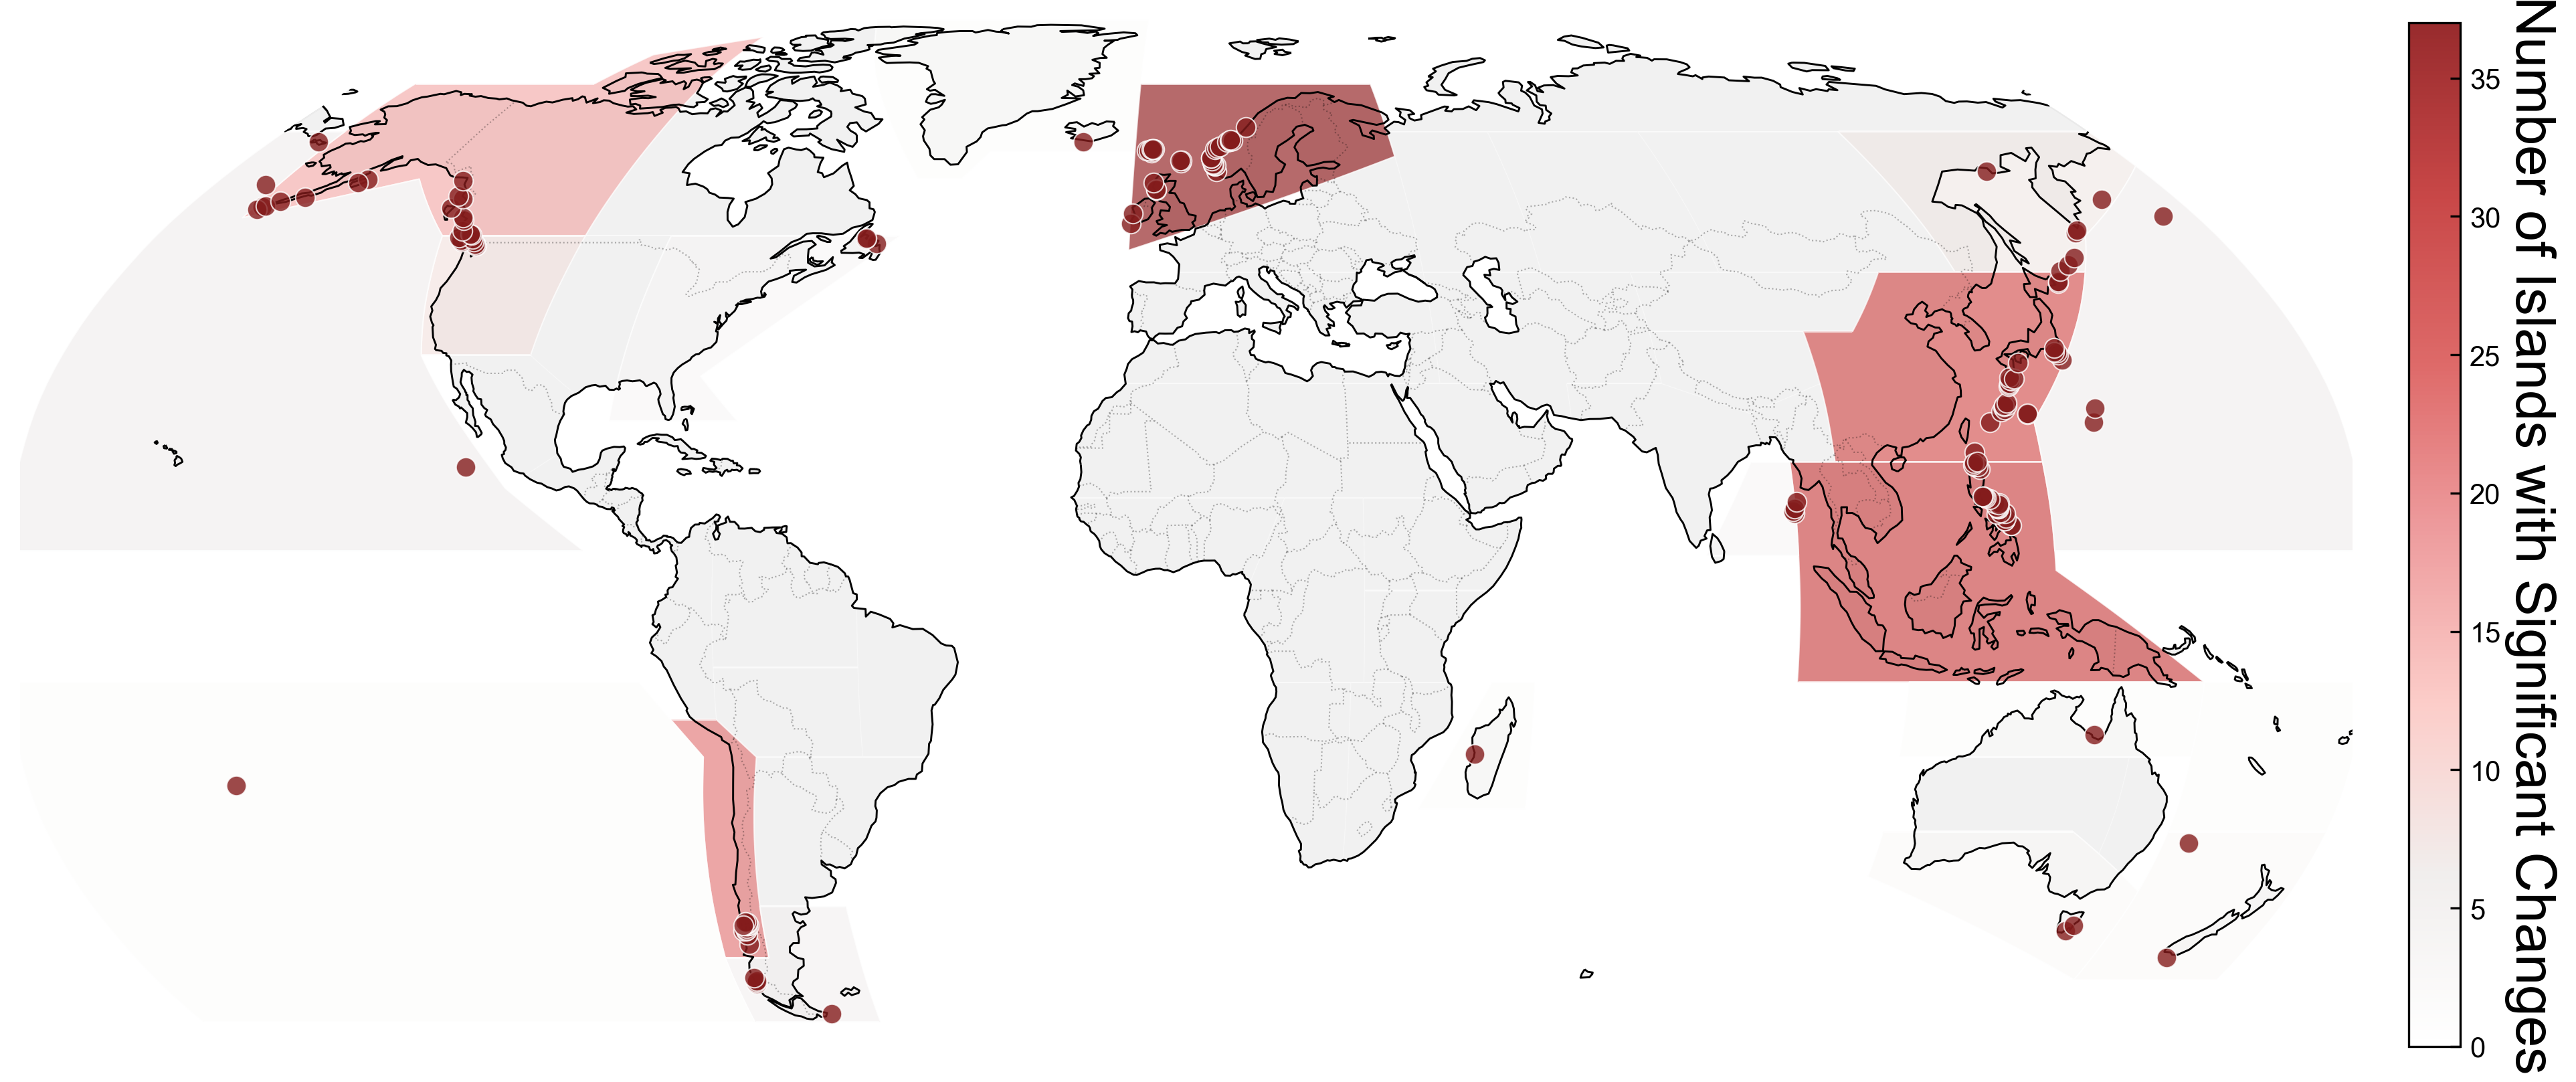


=== 世界地图统计摘要 ===
总共标记了 171 个有显著变化的岛屿
涉及 17 个IPCC区域
变化最多的区域: NEU (37 个岛屿)


In [81]:
# 7. --- 基于有明显变化岛屿的点密度世界地图 ---

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter

print("开始创建点密度世界地图...")

# 计算岛屿变化数据
df_base = df[(df['scenario'] == 'output_0')].copy()
df_compare = df[(df['scenario'] == 'output_2020')].copy()

# 使用现有的calculate_position_change函数
change_data = calculate_position_change(df_base, df_compare)
significant_changes = change_data[change_data['position_change'] > 0.05]  # 显著变化阈值

print(f"发现 {len(significant_changes)} 个有显著变化的岛屿")

if len(significant_changes) > 0:
    # 获取有显著变化岛屿的位置信息
    significant_islands = df_base[df_base['island_id'].isin(significant_changes['island_id'])].copy()
    
    print(f"显著变化岛屿的IPCC区域分布:")
    region_counts = significant_islands['ipcc_region'].value_counts()
    print(region_counts)
    
    # 读取IPCC区域地理数据
    ipcc_regions = gpd.read_file("IPCC-WGI-reference-regions-v4.geojson")

    # 创建世界地图
    fig = plt.figure(figsize=(14, 8.5), dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

    # 设置背景和地图特征
    ax.set_facecolor("#FFFFFF")
    ax.add_feature(cfeature.LAND, color="#CECECE", alpha=0.4)
    ax.add_feature(cfeature.OCEAN, color="#FFFFFF", alpha=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, alpha=0.3)
    
    # 计算每个IPCC区域的显著变化岛屿数量
    if not region_counts.empty:
        # 创建红色渐变色彩映射（白色到深红色）
        vmin, vmax = region_counts.min(), region_counts.max()
        norm = Normalize(vmin=0, vmax=vmax)  # 从0开始，确保没有岛屿的区域为白色
        
        # 创建自定义红色渐变色彩映射
        colors = ['#FFFFFF', '#F1EEED', '#FCCDC9', '#EE9D9F', '#DE6A69', '#C84747', '#982B2D']  # 白色到深红色渐变
        red_colormap = LinearSegmentedColormap.from_list('red_gradient', colors, N=256)
        
        # 为每个IPCC区域着色
        for _, region_row in ipcc_regions.iterrows():
            region_code = region_row['Acronym']
            
            if region_code in region_counts.index:
                # 该区域有显著变化的岛屿
                island_count = region_counts[region_code]
                color = red_colormap(norm(island_count))
                alpha = 0.7  # 有数据的区域更不透明
                
                # 绘制填充的区域
                ax.add_geometries([region_row['geometry']], crs=ccrs.PlateCarree(),
                                  facecolor=color,
                                  edgecolor='white',
                                  linewidth=0.5,
                                  alpha=alpha,
                                  zorder=1)
            else:
                # 该区域没有显著变化的岛屿，保持浅色
                ax.add_geometries([region_row['geometry']], crs=ccrs.PlateCarree(),
                                  facecolor='white',
                                  edgecolor="#FFFFFF",
                                  linewidth=0.3,
                                  alpha=0.3,
                                  zorder=1)
    
    # 在地图上标注显著变化的岛屿点
    if not significant_islands.empty:
        # 使用深红色圆点标记有显著变化的岛屿
        ax.scatter(significant_islands['lon'], significant_islands['lat'],
                   transform=ccrs.PlateCarree(),  # 坐标转换
                   c="#841C1C",  # 深红色点
                   s=50,  # 点大小参数，控制岛屿标记的大小
                   alpha=0.8,  # 透明度参数，让点更加明显
                   edgecolors='white',  # 白色边框
                   linewidth=0.5,  # 边框宽度参数
                   zorder=3)  # 确保点显示在最上层
    
    # 设置视图范围，排除南极洲
    ax.set_extent([-180, 180, -60, 85], crs=ccrs.PlateCarree())
    
    # 添加颜色条图例
    if not region_counts.empty:
        # 创建颜色条
        sm = cm.ScalarMappable(norm=norm, cmap=red_colormap)
        sm.set_array([])
        
        # 在右侧添加颜色条
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', 
                           pad=0.02, shrink=0.6, aspect=20)
        cbar.set_label('Number of Islands with Significant Changes', 
                       rotation=270, labelpad=20, fontsize=20)  # 颜色条标签
        cbar.ax.tick_params(labelsize=10)  # 颜色条刻度标签大小参数
    
    # 添加标题
    # ax.set_title('Global Distribution of Islands with Significant Tariff Changes\n(Baseline vs Climate Stress Scenarios)', 
    #              fontsize=14, fontweight='bold', pad=20)
    
    # 去除坐标轴刻度
    ax.set_xticks([])
    ax.set_yticks([])
    # 去除边框
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # 去除所有边距，只显示图像内容
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.axis('off')
    plt.show()
    
    # 打印统计摘要
    print(f"\n=== 世界地图统计摘要 ===")
    print(f"总共标记了 {len(significant_islands)} 个有显著变化的岛屿")
    print(f"涉及 {len(region_counts)} 个IPCC区域")
    print(f"变化最多的区域: {region_counts.index[0]} ({region_counts.iloc[0]} 个岛屿)")
    
else:
    print("没有发现显著变化的岛屿，无法创建地图可视化")